### 1. Data Load and Preprocessing

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to PyTorch tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # Normalizes to have mean=0.5, std=0.5
])

# Load FashionMNIST datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### 2. Data Visualization

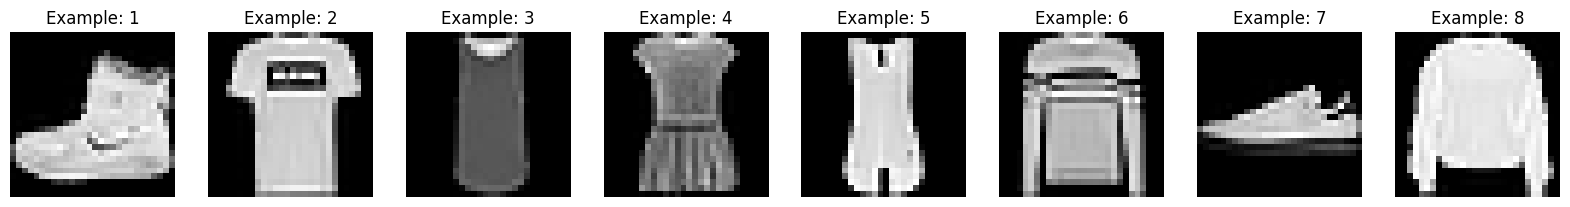

In [11]:
import matplotlib.pyplot as plt

# Display first 8 images from the training set
fig, axes = plt.subplots(1, 8, figsize=(20, 4))
for i in range(8):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray') # img is a 1x28x28 tensor, squeeze removes dimensions of size 1
    axes[i].set_title(f'Example: {i+1}')
    axes[i].axis('off')
plt.show()


### 3. Model Definition

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 300) # Flatten the input in the forward method
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

model = FashionMNISTModel().to(device)
print(model)


FashionMNISTModel(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [13]:
from torchsummary import summary

# Assuming your model is already defined and sent to the device
summary(model, input_size=(1, 28*28))  # For FashionMNIST, input size is (channels, H*W)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
            Linear-2                  [-1, 100]          30,100
            Linear-3                   [-1, 10]           1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.02
Estimated Total Size (MB): 1.02
----------------------------------------------------------------


In [6]:
import torch
from torchviz import make_dot

# Create a dummy input tensor appropriate for your model
dummy_input = torch.randn(1, 28*28, device=device)
# Get the output by forwarding the dummy input through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(dummy_input)

# Visualize the graph; requires the output and parameters
graph = make_dot(output, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
graph.render('model_visualization2', format='png')  # Saves the graph to a file


'model_visualization2.png'

In [7]:
import torch
# Ensure the model is in evaluation mode
model.eval()
# Export the model
torch.onnx.export(model, dummy_input, 'model.onnx', export_params=True, opset_version=11)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic block of ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            # This adds a convolutional layer to the shortcut path to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Element-wise addition
        out = F.relu(out)
        return out

# Define a simple ResNet model for FashionMNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer before the blocks
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Layers of blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classifier
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Number of blocks in each layer
num_blocks = [2, 2, 2, 2]

# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = ResNet(BasicBlock, num_blocks).to(device)
print(model2)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [16]:
# Assuming your model is already defined and sent to the device
summary(model2, input_size=(1, 28, 28))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,864
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
        BasicBlock-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]          36,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
       BasicBlock-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 14, 14]          73,728
      BatchNorm2d-14          [-1, 128,

In [18]:
# Assuming model2 is your defined ResNet model
# Ensure the model is in evaluation mode
model2.eval()

# Create a dummy input tensor with the correct shape [batch_size, channels, height, width]
# For a single grayscale image of size 28x28 pixels
dummy_input = torch.randn(1, 1, 28, 28, device=device)

# Export the model to ONNX format
torch.onnx.export(
    model2, 
    dummy_input, 
    'model2.onnx', 
    export_params=True, 
    opset_version=11,
    input_names=['input'],  # You can specify the input names
    output_names=['output'],  # You can also specify the output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # This makes the model's batch size dynamic
)

### 4. Training the Model

In [21]:
import time
import torch.optim as optim

# Start timer
start_time = time.time()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Assuming the PyTorch training loop here

for epoch in range(15):  # Assuming you're running for 15 epochs
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data to the device

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Optionally, add validation logic inside your training loop

# End timer
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"Training completed in: {duration:.3f} seconds")


Epoch 1, Loss: 0.1982647329568863
Epoch 2, Loss: 0.3017524480819702
Epoch 3, Loss: 0.4683306813240051
Epoch 4, Loss: 0.6021705865859985
Epoch 5, Loss: 0.2026500701904297
Epoch 6, Loss: 0.27873238921165466
Epoch 7, Loss: 0.41515621542930603
Epoch 8, Loss: 0.45533138513565063
Epoch 9, Loss: 0.23996442556381226
Epoch 10, Loss: 0.17839068174362183
Epoch 11, Loss: 0.31937071681022644
Epoch 12, Loss: 0.3001250624656677
Epoch 13, Loss: 0.4046729505062103
Epoch 14, Loss: 0.20801527798175812
Epoch 15, Loss: 0.086492158472538
Training completed in: 204.431 seconds


In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to PyTorch tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalizes to have mean=0.5, std=0.5
])

# Load FashionMNIST datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Assuming model2 is your defined ResNet model
# Ensure the model is in evaluation mode
model.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to monitor test results
y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get prediction from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch prediction results
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:\n', conf_matrix)


Accuracy: 0.8853
Precision: 0.8865
Recall: 0.8853
F1 Score: 0.8852
Confusion Matrix:
 [[877   0  16  11   3   2  86   0   5   0]
 [  8 972   1  12   3   0   3   0   1   0]
 [ 25   0 844   7  78   0  45   0   1   0]
 [ 41   5  15 877  27   0  32   0   3   0]
 [  1   0 101  32 820   0  45   0   1   0]
 [  1   0   0   0   0 965   0  17   0  17]
 [137   1 107  17  76   0 661   0   1   0]
 [  0   0   0   0   0  37   0 929   0  34]
 [ 12   1   6   7   4   7  17   5 941   0]
 [  1   0   0   0   0   8   0  24   0 967]]


In [20]:
import time
import torch.optim as optim
# Start timer
start_time = time.time()
optimizer = optim.Adam(model2.parameters())
criterion = nn.CrossEntropyLoss()

# Assuming the PyTorch training loop here

for epoch in range(15):  # Assuming you're running for 15 epochs
    model2.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data to the device

        optimizer.zero_grad()
        output = model2(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Optionally, add validation logic inside your training loop

# End timer
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"Training completed in: {duration:.3f} seconds")

Epoch 1, Loss: 0.2131364643573761
Epoch 2, Loss: 0.25097158551216125
Epoch 3, Loss: 0.1264793425798416
Epoch 4, Loss: 0.08945557475090027
Epoch 5, Loss: 0.1915014684200287
Epoch 6, Loss: 0.07213769853115082
Epoch 7, Loss: 0.06508186459541321
Epoch 8, Loss: 0.007715204730629921
Epoch 9, Loss: 0.06406931579113007
Epoch 10, Loss: 0.03312810882925987
Epoch 11, Loss: 0.04051384702324867
Epoch 12, Loss: 0.040204647928476334
Epoch 13, Loss: 0.0004991881432943046
Epoch 14, Loss: 0.01711859367787838
Epoch 15, Loss: 0.006040805950760841
Training completed in: 476.395 seconds


In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to PyTorch tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalizes to have mean=0.5, std=0.5
])

# Load FashionMNIST datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Assuming model2 is your defined ResNet model
# Ensure the model is in evaluation mode
model2.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Initialize lists to monitor test results
y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model2(images)

        # Get prediction from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch prediction results
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:\n', conf_matrix)


Accuracy: 0.9341
Precision: 0.9351
Recall: 0.9341
F1 Score: 0.9344
Confusion Matrix:
 [[858   0  19   7   8   1 105   0   2   0]
 [  0 985   0   6   2   0   6   0   1   0]
 [ 11   2 901   7  37   0  42   0   0   0]
 [ 12   1  10 931  26   1  19   0   0   0]
 [  0   0  16  15 926   0  43   0   0   0]
 [  0   0   1   0   0 983   0   9   1   6]
 [ 60   1  32  18  55   0 828   0   6   0]
 [  0   0   0   0   0   3   0 964   0  33]
 [  1   1   2   2   4   2   6   0 982   0]
 [  0   0   0   0   0   2   0  14   1 983]]


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

# Explicitly setting the device to CPU
device = torch.device("cpu")

# Assuming the model definition is already provided
model = FashionMNISTModel().to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Start timer
start_time = time.time()

for epoch in range(15):  # Assuming you're running for 15 epochs
    model.train()
    for data, target in train_loader:
        # Since we're running on CPU, there's no need to call .to(device) on the data and targets
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# End timer
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"Training completed in: {duration:.3f} seconds")
